# (3.1) Create AFA dataset on multiple-imputed dataset
-> just for Mechanism Agent

In [1]:
%load_ext autoreload
%autoreload 2

## Define paths

Paths for data

In [3]:
from afa.configurations.utils_static import specify_default_paths_static
# which dataset to work on 
dataset_name   = "synthetic_1"

# name for of missingness scenario 
miss_scenario  = 'MCAR_1'

# automatically specify some path locations (change paths manually if needed) 
paths = specify_default_paths_static(dataset_name = dataset_name , miss_scenario = miss_scenario) 

Paths for model

In [4]:
# name for agent (and predictor) 
agent_name            = 'Random 10%'
predictor_model_name  = 'logistic_regression'

# new (where to save the model) 
agent_dir           = paths['data_dir']  + 'afa_agents' + '/' + agent_name + '/'
predictor_model_dir = paths['data_dir']  + 'predictor_models' + '/' + predictor_model_name + '/'

In [5]:
mi_model_name   =  'mi_simple'
mi_model_dir  =  paths['data_dir'] + 'mi_models/' + mi_model_name + '/'

# how to name the afa_dataset
afa_dataset_name = mi_model_name 

## Load multiple imputed dataset 
At first, we want to load the dataset 

Includes loading: 
- superfeature mapping
- problem
- afa_problem 
- missingness_model

The dataset has potentially multiple imputations for each missing value. 

In [6]:
from afa.data_modelling.datasets.data_loader.data_loader_static import DataLoader_static
from afa.data_modelling.missingness.multiple_imputation.multiple_imputed_data_loader.multiple_imputed_data_loader_static import MultipleImputedDataLoader_static

2023-02-27 15:37:50.921584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 15:37:51.071788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 15:37:51.071812: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 15:37:51.767533: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [7]:
data_loader = DataLoader_static( data_file                  = paths['data_file'],
                                 superfeature_mapping_file  = paths['superfeature_mapping_file'],
                                 problem_file               = paths['problem_file'],
                                 afa_problem_files          = paths['afa_problem_files'], 
                                 folds_file                 = paths['folds_file'] )
dataset = data_loader.load() 

In [8]:
#load afa_dataset
augmented_data_file = mi_model_dir + 'results.hkl'
mi_model_params = None
mi_data_loader = MultipleImputedDataLoader_static(                   
                    augmented_data_file = augmented_data_file,
                    dataset             = dataset,
                    model_params        = mi_model_params) 
mi_dataset = mi_data_loader.load() 

In [9]:
# define predictor (has to be pretrained) 
predictor_model_params = {
    'name' : predictor_model_name, 
    'directory': predictor_model_dir,
    'base_model_params' : {   
        'model_type': 'ImputeThenRegress',
        'imputer_params' : {
              'model_type': 'simple_imputer',
              'mode' : 'imputation', 
            },
        'predictor_params' : {
              'model_type': 'ann',
              'mode' : dataset.problem, 
              'units':              1,
              'layers': 1,
              'learning_rate': 0.01,
              'batch_size' :128,
              'epochs': 100
          }
    }
}

In [11]:
# define agent
agent_model_params =  None               

In [15]:
# define afa_agent
afa_agent_params = {
    'name' : agent_name,
    'agent_type' : 'mcar_mechanism',
    'directory' : agent_dir, 
    'predictor_params' : predictor_model_params, 
    'agent_params' : agent_model_params,
    'probability' : 0.1 
}

## Initialize Agent 

In [16]:
from afa.afa_models.afa_agents.utils_static import define_afa_agent_static

In [17]:
afa_agent = define_afa_agent_static(     name             = afa_agent_params['name'],  
                                         agent_type       = afa_agent_params['agent_type'],   
                                         afa_agent_params = afa_agent_params,
                                         agent_directory  = afa_agent_params['directory'])

Loading already trained weights for SimpleImputer...
Loading already trained weights for ann...


2023-02-27 15:39:19.970573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-27 15:39:19.970734: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 15:39:19.970814: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-27 15:39:19.970872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-27 15:39:19.970931: W tensorf

## Create afa dataset 

In [18]:
from afa.afa_datasets.afa_dataset_static import AFADataset_static 

In [19]:
### WITHOUT MEMORY TRACKING
# afa_results = afa_agent.predict(dataset,  n_samples = 1) 

## create an afa_dataset out of the generated afa_results
# afa_dataset = AFADataset_static(  dataset = dataset, model = afa_agent, results = afa_results) 

In [27]:
### WITH MEMORY TRACKING
import tracemalloc
tracemalloc.start()

# run agent
afa_results = afa_agent.predict(mi_dataset,  n_samples = 1) 

# create an afa_dataset out of the generated afa_results
afa_dataset = AFADataset_static(  dataset = mi_dataset, model = afa_agent, results = afa_results) 

# displaying the memory
current_memory, max_memory = tracemalloc.get_traced_memory()
print("Checking memory usage during afa dataset creation ... ")
print("current memory usage (after afa dataset creation): {} MB".format(round(current_memory/1000000))  )
print("maximum memory usage (during afa dataset creation): {} MB".format(round(max_memory/1000000))  )
 
# stopping the library
tracemalloc.stop()

Change base_model to constant
Change base_model to constant
Set weight for constant model ...
Set weight for constant model ...
32/32 [==============================] - 0s 2ms/step
Checking memory usage during afa dataset creation ... 
current memory usage (after afa dataset creation): 0 MB
maximum memory usage (during afa dataset creation): 1 MB


In [28]:
# MI data 
# import numpy as np 
# # mi_data, mi_results = mi_dataset.get_augmented_data( ids = np.array([1,2]), n_samples = None)
# mi_data, mi_results = mi_dataset.get_augmented_data(  n_samples = 2)
# print("shape of features of mi data = {}".format(mi_data['feature'].shape))
# # AFA results with MI data
# print("shape of target_R of afa results= {}".format(afa_results['target_superR_hat'].shape))
# print("shape of ids of afa results = {}".format(afa_results['ids'].shape))
# # AFA results retrieved from AFA dataset
# afa_data, afa_data_results = afa_dataset.get_augmented_data(n_samples = 3)
# print("shape of feature from afa_dataset = {}".format(afa_data['feature'].shape))
# print("shape of ids of afa_dataset results = {}".format(afa_data_results['ids'].shape))
# AFA results retrieved from AFA dataset
# afa_data, afa_data_results = afa_dataset.get_augmented_data(n_samples = 3)
# print("shape of feature from afa_dataset = {}".format(afa_data['feature'].shape))
# print("shape of ids of afa_dataset results = {}".format(afa_data_results['ids'].shape))

### Run test for consistency check 

In [29]:
from afa.afa_datasets.testing.test_afa_dataset_static import test_afa_dataset_static
test_afa_dataset_static(afa_dataset)

From AFA dataset: 
cost:  1.74
cost_mc:  1.59
cost_acq:  0.154
From Metrics: 


KeyError: 'cost_mc_env'

In [31]:
# save afa_dataset
afa_dataset.save( directory = agent_dir, afa_dataset_name = afa_dataset_name ) 

## Test loading afa dataset 

In [32]:
from afa.afa_datasets.afa_data_loader.afa_data_loader_static import AFADataLoader_static

In [33]:
augmented_data_file = agent_dir + afa_dataset_name + '_' + 'results.hkl'
afa_data_loader = AFADataLoader_static(                   
                    augmented_data_file = augmented_data_file,
                    dataset  = mi_dataset,
                    model_params = afa_agent_params) 
afa_dataset = afa_data_loader.load() 

Loading already trained weights for SimpleImputer...
Loading already trained weights for ann...


In [34]:
data = afa_dataset.get_data(fold = None, split = None, n_samples =None) 
# data = afa_dataset.get_data(fold = 0, split = 'val', n_samples = 1) 

### Write report

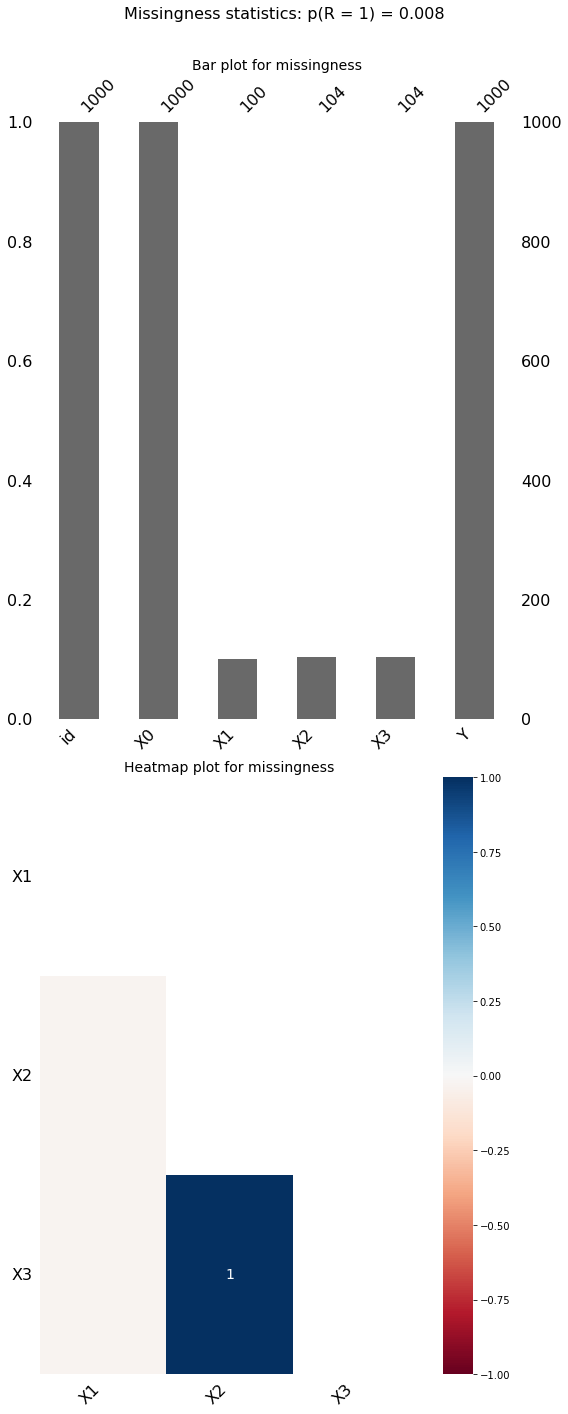

In [35]:
# report 
explanation_file = agent_dir + afa_dataset_name + '_' + 'afa_dataset_report.md'  # +  'reports/' + 'model_report' 
afa_dataset.explain(file= explanation_file, format = 'markdown')